In [13]:
# Imports.
import numpy as np
import numpy.random as npr
import pygame as pg
import pandas as pd

from SwingyMonkeyNoAnimation import SwingyMonkey
from SwingyMonkey import SwingyMonkey as GraphicalSwingyMonkey


X_BINSIZE = 200
Y_BINSIZE = 100
X_SCREEN = 1400
Y_SCREEN = 900
GRAV_RANGE = 2
VEL_RANGE = 80
VEL_BINSIZE = 80
class Learner(object):
    '''
    This agent jumps randomly.
    '''

    def __init__(self,gamma= 0.75,alpha=0.4,epsilon=0.1):
        self.last_state  = None
        self.last_action = None
        self.last_reward = None
        self.gravity = None 
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        # We initialize our Q-value grid that has an entry for each action and state.
        # (action, rel_x, rel_y)
        self.Q = np.zeros((2, X_SCREEN // X_BINSIZE, Y_SCREEN // Y_BINSIZE , 2, VEL_RANGE // VEL_BINSIZE +1))

    def reset(self):
        self.last_state  = None
        self.last_action = None
        self.last_reward = None
        self.gravity = None 
    def discretize_state(self, state):
        '''
        Discretize the position space to produce binned features.
        rel_x = the binned relative horizontal distance between the monkey and the tree
        rel_y = the binned relative vertical distance between the monkey and the tree        
        '''
        
        rel_x = int((state["tree"]["dist"]) // X_BINSIZE)
        rel_y = int((state["tree"]["top"] - state["monkey"]["top"]) // Y_BINSIZE)
        velocity =  int((state['monkey']['vel']))
        velocity =  (int(state['monkey']['vel'])+50) // VEL_BINSIZE
#         print((state['monkey']['vel']))
        return (rel_x, rel_y, velocity) 

    def q_learn(self,curr_state):
        curr_state
        if self.last_action is not None:
            old_quality = self.Q[self.last_action,self.last_state[0],self.last_state[1],self.gravity,self.last_state[2]] 
            future_reward = self.gamma*max(self.Q[:,curr_state[0],curr_state[1],self.gravity, curr_state[2]])
            updated_quality = (1-self.alpha)*old_quality + self.alpha*(self.last_reward+future_reward) 
            self.Q[self.last_action,self.last_state[0],self.last_state[1],self.gravity,self.last_state[2]] = updated_quality
#             print(">>>",updated_quality)
    
    def final_q_learn(self):
        
        if self.last_action is not None:
            old_quality = self.Q[self.last_action,self.last_state[0],self.last_state[1],self.gravity, self.last_state[2]] 
            updated_quality = (1-self.alpha)*old_quality + self.alpha*(self.last_reward) 
            self.Q[self.last_action,self.last_state[0],self.last_state[1],self.gravity, self.last_state[2]] = updated_quality
                
                
    def action_callback(self, state):
        '''
        Implement this function to learn things and take actions.
        Return 0 if you don't want to jump and 1 if you do.
        '''

        # TODO (currently monkey just jumps around randomly)
        # 1. Discretize 'state' to get your transformed 'current state' features.
        # 2. Perform the Q-Learning update using 'current state' and the 'last state'.
        # 3. Choose the next action using an epsilon-greedy policy.
        
        # Q Learning
        
        if (self.last_state is not None) and (self.gravity is None):
            velocity_change=state['monkey']['vel'] - self.last_state[2] 
            self.gravity = 0 if velocity_change==-4 else 1
#             self.gravity = 0
            
        curr_state = self.discretize_state(state)
        self.q_learn(curr_state)
        
        # pick an action
        self.epsilon /= 2
#         self.alpha /= 1.2
        exploring = npr.rand() < self.epsilon

        if exploring or self.gravity is None:
            new_action = npr.randint(0,2)
        else:
            new_action  = np.argmax(self.Q[:,curr_state[0],curr_state[1],self.gravity,curr_state[2]])

        self.last_action = new_action
        self.last_state  = curr_state

        return new_action

    def reward_callback(self, reward):
        '''This gets called so you can see what reward you get.'''
        if reward>0:
            self.last_reward = 5
        else:
            self.last_reward = reward


def run_games(learner, hist, iters = 100, t_len = 100):
    '''
    Driver function to simulate learning by having the agent play a sequence of games.
    '''
    for ii in range(iters):
        # Make a new monkey object.
        swing = SwingyMonkey(sound=False,                  # Don't play sounds.
                             text="Epoch %d" % (ii),       # Display the epoch on screen.
                             tick_length = t_len,          # Make game ticks super fast.
                             action_callback=learner.action_callback,
                             reward_callback=learner.reward_callback)

        # Loop until you hit something.
        while swing.game_loop():
            pass
        learner.final_q_learn()
        
        # Save score history.
        hist.append(swing.score)

        # Reset the state of the learner.
#         print('\n\n>>>>',learner.Q)
        learner.reset()
    pg.quit()
    return


# if __name__ == '__main__':

    # Select agent.
best_performance = 0
best_hps = []

hyperparameters={'alpha':[], 'gamma': [], 'epsilon': [], 'performance': []}
for alpha in [i/10 for i in range(1,10)]:
    for gamma in [i/10 for i in range(1,10)]:
        for epsilon in [i/10 for i in range(1,10)]:
            agent = Learner(gamma,alpha,epsilon)

            # Empty list to save history.
            hist = []
            alpha,gamma, epsilon= 0.2, 0.9,0.5
            # Run games. You can update t_len to be smaller to run it faster.
            run_games(agent, hist, 100, 100)
            if best_performance < max(hist):
                best_hps,best_performance = [gamma,alpha,epsilon], max(hist)
            # Save history. 
            np.save('hist',np.array(hist))

            print(f'gamma={gamma},alpha={alpha},epsilon={epsilon}, performance={max(hist)}')
            hyperparameters['gamma'].append(gamma)
            hyperparameters['alpha'].append(alpha)
            hyperparameters['epsilon'].append(epsilon)
            hyperparameters['performance'].append(max(hist))

            break
        break
    break
    
print(f'gamma={best_hps[0]},alpha={best_hps[1]},epsilon={best_hps[2]}, performance={best_performance}')


gamma=0.9,alpha=0.2,epsilon=0.5, performance=57
gamma=0.9,alpha=0.2,epsilon=0.5, performance=57


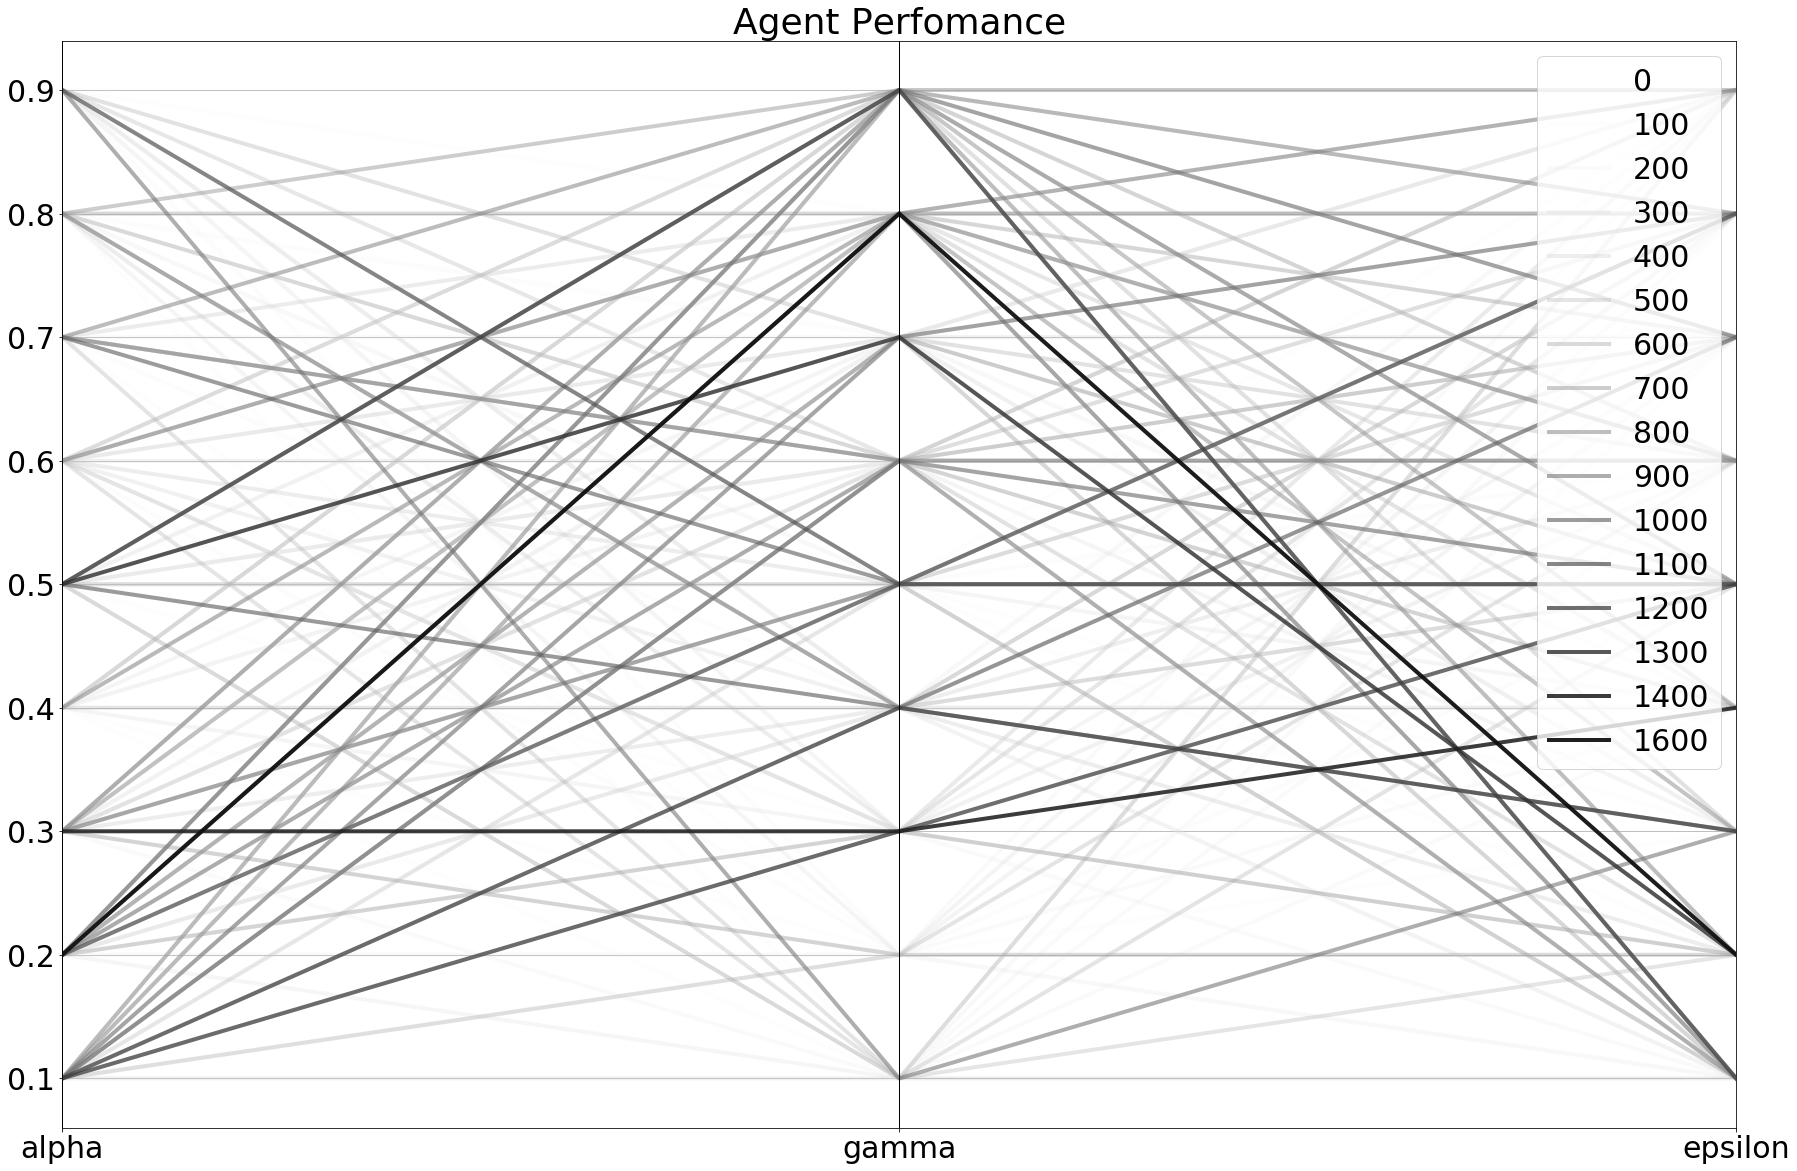

In [20]:
from matplotlib import pyplot as plt

PERFORMANCE_BINSIZE = 100
df = pd.DataFrame(hyperparameters)
df = df.sort_values('performance')
df['color'] = (df['performance']//PERFORMANCE_BINSIZE)*PERFORMANCE_BINSIZE
df = df.drop('performance',axis=1)

plt.figure(figsize=(30,20))

ax = pd.plotting.parallel_coordinates(df,'color',
                                      linewidth=4,
                                      color=[(1-i/(max(df.color)/PERFORMANCE_BINSIZE),
                                              1-i/(max(df.color)/PERFORMANCE_BINSIZE),
                                              1-i/(max(df.color)/PERFORMANCE_BINSIZE),
                                              i/(max(df.color)/PERFORMANCE_BINSIZE))
                                                                    for i in range(max(df.color))])
ax.set_title("Agent Perfomance")
plt.rcParams.update({"font.size":30})
plt.savefig("fig1.png")

In [14]:
def graphical_run_games(learner, hist, iters = 100, t_len = 100):
    '''
    Driver function to simulate learning by having the agent play a sequence of games.
    '''
    for ii in range(iters):
        # Make a new monkey object.
        swing = GraphicalSwingyMonkey(sound=False,                  # Don't play sounds.
                             text="Epoch %d" % (ii),       # Display the epoch on screen.
                             tick_length = int(t_len//3),          # Make game ticks super fast.
                             action_callback=learner.action_callback,
                             reward_callback=learner.reward_callback)

        # Loop until you hit something.
        while swing.game_loop():
            pass
        learner.final_q_learn()
        
        # Save score history.
        hist.append(swing.score)

        # Reset the state of the learner.
        learner.reset()
    pg.quit()
    return


hist = []
graphical_run_games(Learner(gamma=best_hps[0],alpha=best_hps[1],epsilon=best_hps[2]),hist=hist)

SystemExit: 

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
